## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the gridded methane emissions data product.
2. Pass the STAC item into the raster API `/stac/tilejson.json `endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

   

## About the Data

he NASA Carbon Monitoring System Flux (CMS-Flux) team analyzed remote sensing observations from Japan’s Greenhouse gases Observing SATellite (GOSAT) to produce the global Committee on Earth Observation Satellites (CEOS) CH₄ Emissions data product. They used an analytic Bayesian inversion approach and the GEOS-Chem global chemistry transport model to quantify annual methane (CH₄) emissions and their uncertainties at a spatial resolution of 1° by 1° and then projected these to each country for 2019.

# Installing the Required Libraries
Please run the next cell to install all the required libraries to run the notebook.

In [12]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Querying the STAC API

In [13]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [14]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

# Please use the collection name similar to the one used in STAC collection.

# Name of the collection for gosat budget methane. 
collection_name = "gosat-based-ch4budget-yeargrid-v1"

In [15]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'gosat-based-ch4budget-yeargrid-v1',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1'}],
 'title': 'GOSAT-based Top-down Methane Budgets.',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180.5, -90.5, 179.5, 89.5]]},
  'temporal': {'interval': [['2019-01-01T00:00:00+00:00',
     '2019-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2012 to December 2018. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [ ]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [16]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 1 items


In [17]:
# Examining the first item in the collection
items[0]

{'id': 'gosat-based-ch4budget-yeargrid-v1-2019',
 'bbox': [-180.5, -90.5, 179.5, 89.5],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1/items/gosat-based-ch4budget-yeargrid-v1-2019'}],
 'assets': {'post-gas': {'href': 's3://ghgc-data-store/gosat-based-ch4budget-yeargrid-v1/TopDownEmissions_GOSAT_post_gas_GEOS_CHEM_2019.tif',
   'type': 'image/tiff; applicat

Below, we enter minimum and maximum values to provide our upper and lower bounds in `rescale_values.`

## Exploring Changes in GOSAT Methane budgets (CH4) Levels Using the Raster API

In this notebook, we will explore the impacts of methane emissions and by examining changes over time in urban regions. We will visualize the outputs on a map using `folium.`

In [18]:
# To access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:10]: item for item in items} 
asset_name = "prior-total"

In [19]:
# Fetching the min and max values for a specific item
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

In [27]:
items.keys()

dict_keys(['2019-01-01'])

Now, we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this for first January 2019.

In [28]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2019_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2019-01-01']['collection']}&item={items['2019-01-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2019_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://1w7hfngnp7.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=gosat-based-ch4budget-yeargrid-v1&item=gosat-based-ch4budget-yeargrid-v1-2019&assets=prior-total&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0.0%2C2.121816635131836'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.5, -90.5, 179.5, 89.5],
 'center': [-0.5, -0.5, 0]}

## Visualizing CH₄ emissions


In [32]:
# We will import folium to map and folium.plugins to allow side-by-side mapping
import folium
import folium.plugins

# Set initial zoom and center of map for CH₄ Layer
# Centre of map [latitude,longitude]
map_ = folium.Map(location=(34, -118), zoom_start=6)

# January 2019
map_layer_2018 = TileLayer(
    tiles=january_2019_tile["tiles"][0],
    attr="GHG",
    opacity=0.7,
)
map_layer_2018.add_to(map_)

# # January 2012
# map_layer_2012 = TileLayer(
#     tiles=january_2012_tile["tiles"][0],
#     attr="GHG",
#     opacity=0.7,
# )
# map_layer_2012.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [33]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [34]:
# We will plug in the coordinates for a location inside the the polygon and a zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [35]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 1 items


In [36]:
# Explore the first item
items[0]

{'id': 'gosat-based-ch4budget-yeargrid-v1-2019',
 'bbox': [-180.5, -90.5, 179.5, 89.5],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://e6v7j4ejp6.execute-api.us-west-2.amazonaws.com/api/stac/collections/gosat-based-ch4budget-yeargrid-v1/items/gosat-based-ch4budget-yeargrid-v1-2019'}],
 'assets': {'post-gas': {'href': 's3://ghgc-data-store/gosat-based-ch4budget-yeargrid-v1/TopDownEmissions_GOSAT_post_gas_GEOS_CHEM_2019.tif',
   'type': 'image/tiff; applicat

In [38]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [39]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 18.4 ms, sys: 3.31 ms, total: 21.8 ms
Wall time: 424 ms


In [40]:
stats[0]

{'statistics': {'b1': {'min': 0.0056354631669819355,
   'max': 0.2015725076198578,
   'mean': 0.06195338567097982,
   'count': 24.0,
   'sum': 1.4868812561035156,
   'std': 0.04585536439075071,
   'median': 0.059481002390384674,
   'majority': 0.0056354631669819355,
   'minority': 0.0056354631669819355,
   'unique': 24.0,
   'histogram': [[6.0, 3.0, 4.0, 5.0, 3.0, 1.0, 1.0, 0.0, 0.0, 1.0],
    [0.0056354631669819355,
     0.025229167193174362,
     0.044822871685028076,
     0.06441657990217209,
     0.0840102806687355,
     0.10360398888587952,
     0.12319768965244293,
     0.14279139041900635,
     0.16238510608673096,
     0.18197880685329437,
     0.2015725076198578]],
   'valid_percent': 66.67,
   'masked_pixels': 12.0,
   'valid_pixels': 24.0,
   'percentile_2': 0.006904181102290749,
   'percentile_98': 0.17223968714475626}},
 'datetime': '2019-01-01T00:00:00+00:00'}

In [41]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2019-01-01T00:00:00+00:00,0.005635,0.201573,0.061953,24.0,1.486881,0.045855,0.059481,0.005635,0.005635,24.0,"[[6.0, 3.0, 4.0, 5.0, 3.0, 1.0, 1.0, 0.0, 0.0,...",66.67,12.0,24.0,0.006904,0.17224,2019-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the gridded methane emission (Domestic Wastewater Treatment & Discharge (5D)) time series (January 2000 -December 2021) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

Text(0.5, 1.0, 'CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-202)')

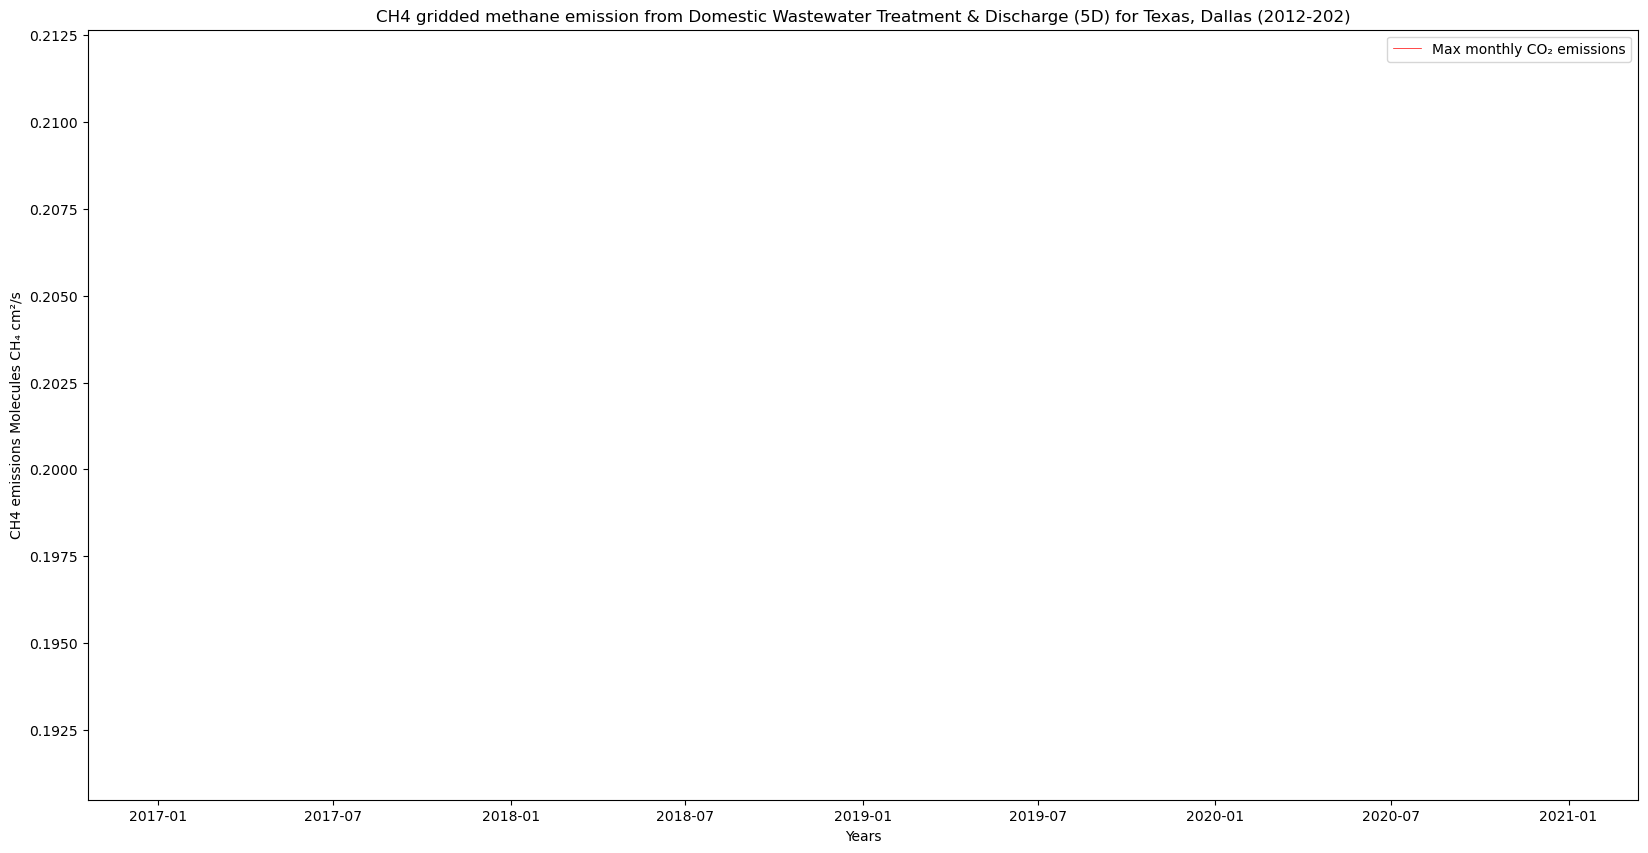

In [42]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Max monthly CO₂ emissions",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("CH4 emissions Molecules CH₄ cm²/s")
plt.title("CH4 gridded methane emission from Domestic Wastewater Treatment & Discharge (5D) for Texas, Dallas (2012-202)")

In [45]:
print(items[0]["properties"]["start_datetime"])

2019-01-01T00:00:00+00:00


In [47]:
tile_2016 = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[0]['collection']}&item={items[0]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
tile_2016

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://1w7hfngnp7.execute-api.us-west-2.amazonaws.com/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=gosat-based-ch4budget-yeargrid-v1&item=gosat-based-ch4budget-yeargrid-v1-2019&assets=prior-total&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=0.0%2C2.121816635131836'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.5, -90.5, 179.5, 89.5],
 'center': [-0.5, -0.5, 0]}

In [48]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=tile_2016["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for gridded methane emissions.